In [1]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from barn.utils import get_frame, divide_into_segments, count_barnacles, BarnacleDataset

libpng warning: iCCP: known incorrect sRGB profile


True

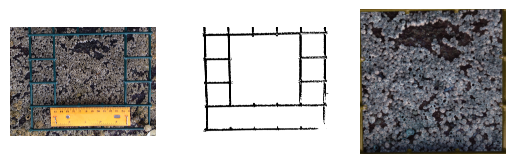

In [2]:
import os
if not os.path.exists("cropped"):
    os.mkdir("cropped")
image, x, y, w, h = get_frame("Barnacles/img1.png")
cv2.imwrite("cropped/img1.png", image[y:y+h,x:x+w])

mask = cv2.imread("Barnacles/mask1.png")
cv2.imwrite("cropped/mask1.png", mask[y:y+h,x:x+w])

image, x, y, w, h = get_frame("Barnacles/img2.png")
cv2.imwrite("cropped/img2.png", image[y:y+h,x:x+w])

mask = cv2.imread("Barnacles/mask2.png")
cv2.imwrite("cropped/mask2.png", mask[y:y+h,x:x+w])

image, x, y, w, h = get_frame("Barnacles/unseen_img1.png")
cv2.imwrite("cropped/unseen_img1.png", image[y:y+h,x:x+w])

In [3]:
if not os.path.exists("train"):
    os.mkdir("train")
    os.mkdir("train/data")
    os.mkdir("train/mask")
if not os.path.exists("test"):
    os.mkdir("test")

for image_dir in os.listdir("cropped"):
    image = cv2.imread("cropped/"+image_dir)
    segments = divide_into_segments(image, (10,10))
  
    print(len(segments))
    if "unseen" in image_dir:
        for i,segment in enumerate(segments):
            cv2.imwrite(os.path.join("test",os.path.splitext(image_dir)[0]+f"seg{i}.png"),segment)
    elif "img" in image_dir:
        for i,segment in enumerate(segments):
            cv2.imwrite(os.path.join("train","data",os.path.splitext(image_dir)[0]+f"seg{i}.png"),segment)
    else:
        for i,segment in enumerate(segments):
            cv2.imwrite(os.path.join("train","mask",os.path.splitext(image_dir)[0]+f"seg{i}.png"),segment)

100
100
100
100
100


In [4]:
import random
import shutil

# Getting validation split from data

if not os.path.exists("val"):
    os.mkdir("val")
    os.mkdir("val/data")
    os.mkdir("val/mask")

    image_files = sorted(os.listdir("train/data"))  # Ensure consistent order
    mask_files = sorted(os.listdir("train/mask"))

    val_ratio = 0.2  # 20% for validation

    random.seed(42) 
    total_files = len(image_files)
    val_indices = random.sample(range(total_files), int(total_files * val_ratio))

    for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
        if i in val_indices:
            shutil.move(os.path.join("train/data", image_file), os.path.join("val/data", image_file))
            shutil.move(os.path.join("train/mask", mask_file), os.path.join("val/mask", mask_file))

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.Resize((256, 256),),  # Resize to a fixed size
    transforms.ToTensor(),  # Convert to PyTorch Tensor
])

# Create dataset instances
train_dataset = BarnacleDataset(
    image_dir='train/data',
    mask_dir='train/mask',
    transform=transform
)

val_dataset = BarnacleDataset(
    image_dir='val/data',
    mask_dir='val/mask',
    transform=transform
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

200 200
40 40


/Users/dylanthomas/miniconda3/envs/dali/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dylanthomas/miniconda3/envs/dali/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NEW BEST MODEL FOUND: SAVING MODEL
Epoch 1/10, Train Loss: 0.4508733135461807, Val Loss: 0.3878858685493469
NEW BEST MODEL FOUND: SAVING MODEL
Epoch 2/10, Train Loss: 0.3239317262172699, Val Loss: 0.29704931378364563
NEW BEST MODEL FOUND: SAVING MODEL
Epoch 3/10, Train Loss: 0.283609062731266, Val Loss: 0.23361220955848694
NEW BEST MODEL FOUND: SAVING MODEL
Epoch 4/10, Train Loss: 0.24973467975854874, Val Loss: 0.19479428231716156
Epoch 5/10, Train Loss: 0.2264335936307907, Val Loss: 0.2525811195373535
Epoch 6/10, Train Loss: 0.20987044304609298, Val Loss: 0.22802864015102386
NEW BEST MODEL FOUND: SAVING MODEL
Epoch 7/10, Train Loss: 0.1996152338385582, Val Loss: 0.13384276628494263
Epoch 8/10, Train Loss: 0.18665333420038224, Val Loss: 0.1805952787399292
Epoch 9/10, Train Loss: 0.17467398911714554, Val Loss: 0.1495133638381958
NEW BEST MODEL FOUND: SAVING MODEL
Epoch 10/10, Train Loss: 0.16745023146271706, Val Loss: 0.11782409995794296


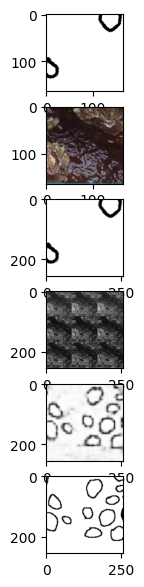

In [6]:
from torch import nn, optim
from torchvision.models.segmentation import fcn_resnet50
from torchvision.transforms.functional import to_pil_image

# ChatGPT used to generate boilerplate for training loop, which is tedious

# Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the FCN model with ResNet-50 backbone
model = fcn_resnet50(pretrained=True,)  # Load pretrained weights
model.classifier[4] = nn.Conv2d(512, 1, kernel_size=1)
model.to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # For segmentation tasks
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10

fig = plt.figure(figsize=(10, 7))

min_loss = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = torch.sigmoid(model(images)["out"])  # FCN returns a dictionary with "out"

        # Compute loss
        loss = criterion(outputs, masks.float())
        running_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        plt.subplot(6, 1, 5)
        plt.imshow(outputs[2].detach().squeeze(),cmap="gray")

        plt.subplot(6, 1, 6)
        plt.imshow(masks[2].squeeze(),cmap="gray")

    model.eval()

    val_running_loss = 0
    for images, masks in val_loader:

        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = torch.sigmoid(model(images)["out"])  # FCN returns a dictionary with "out"

        # Compute loss
        val_loss = criterion(outputs, masks.float())
        val_running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    val_avg_loss = val_running_loss / len(val_loader)

    if min_loss == None or val_avg_loss < min_loss:
        print("NEW BEST MODEL FOUND: SAVING MODEL")
        min_loss = val_avg_loss
        torch.save(model.state_dict(), "fcn_resnet50_barnacle.pth")

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss}, Val Loss: {val_avg_loss}")


(256, 256, 3)
WE DETECT 18 barnacles


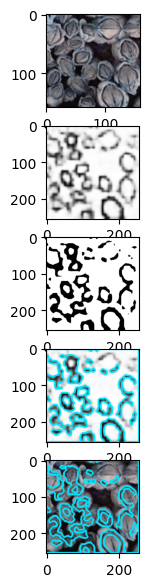

In [7]:
import random

fig = plt.figure(figsize=(10, 7))

i = random.randint(0,99)

test_image = cv2.imread(f"test/unseen_img1seg{i}.png")

proc_image = transform(test_image)

# out = torch.round(torch.sigmoid(model(proc_image.unsqueeze(0))["out"]))
out = torch.sigmoid(model(proc_image.unsqueeze(0))["out"]).detach().squeeze().numpy()
out = cv2.normalize(out, None, alpha=0, beta=255,norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)

plt.subplot(5,1,1)
plt.imshow(test_image)

plt.subplot(5,1,2)
plt.imshow(out,cmap="gray")

count, contours = count_barnacles(out)

img_w_contours = out.copy()
org_w_contours = cv2.resize(test_image,(256,256))

print(org_w_contours.shape)

cv2.drawContours(img_w_contours, contours, -1, (0,255,0))

plt.subplot(5,1,4)

img_w_contours = np.expand_dims(img_w_contours, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(contours):
    img_w_contours = cv2.drawContours(img_w_contours, contours, k, (0, 230, 255), 4)
    org_w_contours = cv2.drawContours(org_w_contours, contours, k, (0, 230, 255), 4)
plt.imshow(img_w_contours)

plt.subplot(5,1,5) 
plt.imshow(org_w_contours)

print(f"WE DETECT {count} barnacles")